# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?


***Workflow***

* Exporatory Data Analysis (EDA)
  *   Statistical analysis of the corpus/content based on the frequencies of words and phrases.

    1.   Calculate summary statistics
    2.   Check for missing values
    3.   Plot distributions of interesting attributes
    4.   Compare distributions across categories

* Pre-processing
  *   Lowercasing, sentence segmentation, word tokenization and stop word removal
  *   Stemming and lemmatization, removing digits, punctuation, mispelling correction, etc
* Feature Engineering
  * Vectorization
* Modeling
  * Naive Bayes
  * Support Vector Machines
  * Logistic Regression
* Evaluation




In [ ]:
pip install textacy

In [ ]:
pip install spacy

In [ ]:
pip install -U pip setuptools wheel

In [ ]:
pip install mglearn

In [ ]:
pip install eli5

In [ ]:
pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import wordcloud
import requests
import json
import re
import textacy.preprocessing as tprep
import spacy 
import mglearn
import warnings
import eli5
import gensim.downloader as api
import keras
import pickle


from itertools import combinations
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer 
from unicodedata import normalize
from wordcloud import WordCloud
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from gensim.models import word2vec, KeyedVectors
from keras import backend as K
from scipy.stats import reciprocal

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
import spacy.cli
spacy.cli.download("es_core_news_sm")

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_json('/content/drive/MyDrive/dataset_es_train.json', lines=True)

In [ ]:
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [ ]:
data.shape

(200000, 8)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         200000 non-null  object
 1   product_id        200000 non-null  object
 2   reviewer_id       200000 non-null  object
 3   stars             200000 non-null  int64 
 4   review_body       200000 non-null  object
 5   review_title      200000 non-null  object
 6   language          200000 non-null  object
 7   product_category  200000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.2+ MB


In [ ]:
data.nunique()

review_id           200000
product_id          150938
reviewer_id         179076
stars                    5
review_body         198264
review_title        112114
language                 1
product_category        30
dtype: int64

In [ ]:
data.drop('language', axis=1, inplace=True)

In [ ]:
data.duplicated().any()

False

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

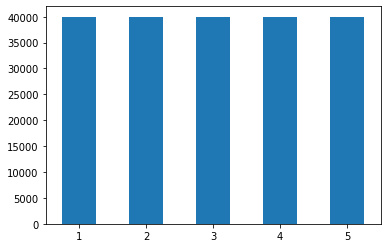

In [ ]:
data.stars.value_counts(ascending=True).plot.bar()
plt.xticks(rotation=0)

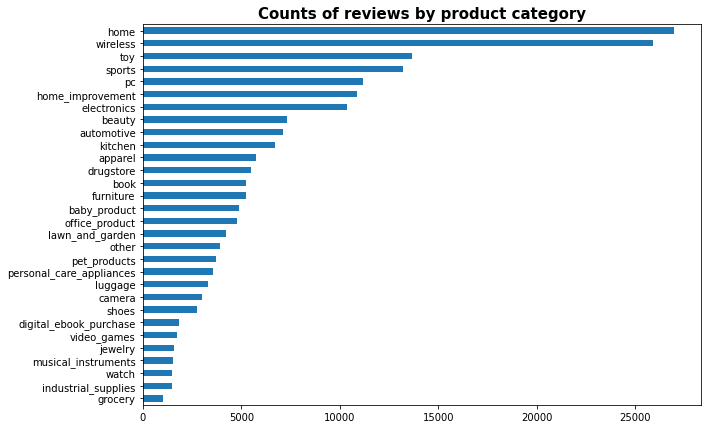

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Counts of reviews by product category', pad=6, fontsize=15, fontweight='bold')
data.product_category.value_counts(ascending=True).plot(kind='barh')

<BarContainer object of 30 artists>

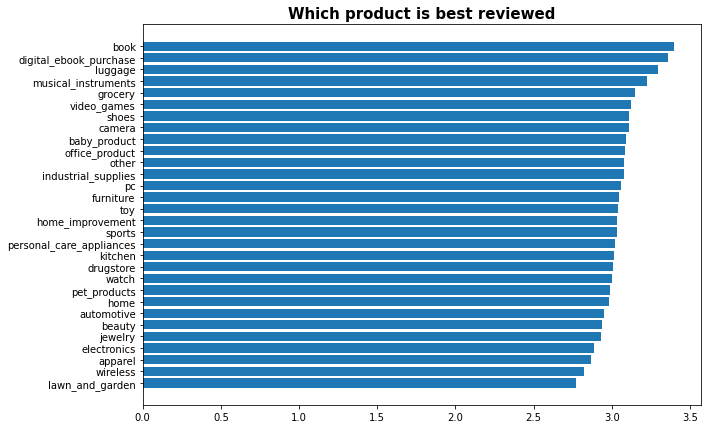

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Which product is best reviewed', pad=6, fontsize=15, fontweight='bold')
review_df = data.groupby(['product_category']).mean().sort_values(by='stars')
plt.barh(review_df.index, review_df.stars)

In [ ]:
data.describe(include='O')

,review_id,product_id,reviewer_id,review_body,review_title,product_category
count,200000,200000,200000,200000,200000,200000
unique,200000,150938,179076,198264,112114,30
top,es_0870660,product_es_0261843,reviewer_es_0588051,Buena relación calidad precio,Bien,home
freq,1,8,7,106,1952,26962


What products often have most reviews together?

In [ ]:
mask = data.reviewer_id.value_counts() > 1
concurrent_reviewers = data.loc[data.reviewer_id.isin([i for i in mask.index if mask[i] == True])]
concurrent_reviewers.sort_values(by='reviewer_id').head(6)

# len([i for i in mask.index if mask[i] == True])
# len(np.where(data.reviewer_id.value_counts()>1)[0])

,review_id,product_id,reviewer_id,stars,review_body,review_title,product_category
9359,es_0659010,product_es_0610232,reviewer_es_0000080,1,"Se rompieron en el primer uso, uno de los kits...","No duran nada, plásticos malos.",industrial_supplies
67898,es_0787109,product_es_0880733,reviewer_es_0000080,2,"Le bajo a dos estrellas, primero por la constr...",Un poco desastre,pc
36777,es_0968474,product_es_0429554,reviewer_es_0000108,1,"es un trozo de poliespan forrado de tela, supe...",no me ha gustado nada!!!,automotive
172273,es_0965492,product_es_0547522,reviewer_es_0000108,5,tiene buena pinta lo que psa que se oye un pel...,manos libres,wireless
55950,es_0449925,product_es_0885629,reviewer_es_0000169,2,La batería dura muy poco,La batería apenas dura,electronics
54969,es_0519492,product_es_0677625,reviewer_es_0000169,2,La trabilla de la pulsera me ha durado apenas ...,Muy fragil,sports


In [ ]:
combination_df = concurrent_reviewers.groupby('reviewer_id').transform(lambda x: ', '.join(x))
combination_df = combination_df['product_category'].drop_duplicates()
combination_df

9                  kitchen, digital_ebook_purchase
11                              home, pet_products
12        wireless, other, home_improvement, shoes
14                            wireless, automotive
20                          furniture, electronics
                            ...                   
180165                     furniture, toy, kitchen
181805            musical_instruments, sports, toy
183406                  drugstore, pc, electronics
189366                    toy, camera, electronics
196321          digital_ebook_purchase, automotive
Name: product_category, Length: 2929, dtype: object

In [ ]:
count = Counter()

for row in combination_df:
  row = list(set(row.split(', ')))
  count.update(Counter(combinations(row,2)))

In [ ]:
count.most_common(10)

[(('sports', 'home'), 100),
 (('sports', 'wireless'), 94),
 (('toy', 'home'), 91),
 (('pc', 'wireless'), 90),
 (('electronics', 'wireless'), 84),
 (('pc', 'home'), 77),
 (('electronics', 'home'), 75),
 (('home', 'wireless'), 73),
 (('wireless', 'home'), 71),
 (('beauty', 'home'), 68)]

### Pre-Processing for EDA

In [ ]:
analysis_df = data.copy()

In [ ]:
def clean(text):
  # tags like <tab>
  text = re.sub(r'<[^<>]*>', ' ', text)
  # markdown URLs like [Some text](https://....)
  text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
  text = ''.join([i for i in text if i not in ['[',']']])
  # text or code in brackets like [0]
  text = re.sub(r'\[[^\[\]]*\]', ' ', text)
  # standalone sequences of specials, matches &# but not #cool
  text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
  # standalone sequences of hyphens like --- or ==
  text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
  # sequences of white spaces
  text = re.sub(r'\s+', ' ', text)
  return text.strip()

In [ ]:
analysis_df['review_body'] = analysis_df.review_body.apply(lambda x: ' '.join(['la' if i == 'ka' else 'que' if i == 'q' else 'con' if i == 'co' else i for i in word_tokenize(x)]))
analysis_df["clean_body"] = analysis_df["review_body"].str.replace(pat=r"\&\#[0-9]+\;", repl="", regex=True)
analysis_df["clean_body"] = analysis_df["review_body"].apply(clean)

In [ ]:
# Case-folding into lower case
analysis_df['clean_body'] = analysis_df.clean_body.str.lower()

In [ ]:
# Removing accent marks
def no_accent_marks(row):
  s = row 
  trans_tab = dict.fromkeys(map(ord, u'\u0301\u0308'), None)
  s = normalize('NFKC', normalize('NFKD', s).translate(trans_tab))
  return s

In [ ]:
analysis_df['clean_body'] = analysis_df.clean_body.apply(no_accent_marks)

In [ ]:
def normalize_text(text):
  text = tprep.normalize_hyphenated_words(text)
  text = tprep.normalize_quotation_marks(text)
  text = tprep.normalize_unicode(text)
  return text

In [ ]:
 analysis_df['clean_body'] =  analysis_df.clean_body.apply(lambda x: re.sub(r"[`'\",.!?():]", " ", x).replace('-',' ').replace('/', ''))
 analysis_df['clean_body'] =  analysis_df.clean_body.apply(lambda x: re.sub(r'\s+', ' ', x))

In [ ]:
# # Tokenization (process of extracting words from a sequence of characters)
def token_analysis(df_column):
  token = word_tokenize(df_column)
  return token

In [ ]:
analysis_df['tokens'] = analysis_df.clean_body.apply(token_analysis)

In [ ]:
analysis_df.tokens.head()

0    [nada, bueno, se, me, fue, la, pantalla, en, m...
1    [horrible, nos, tuvimos, que, comprar, otro, p...
2    [te, obligan, a, comprar, dos, unidades, y, te...
3    [no, entro, en, descalificar, al, vendedor, so...
4        [llega, tarde, y, con, la, talla, equivocada]
Name: tokens, dtype: object

In [ ]:
w_cloud_df = analysis_df.tokens

**Removing stop words**

Classification and retrieval do not usually require an in-depth understanding of the text, so we can remove stopwords.

In [ ]:
with open('/content/drive/MyDrive/stopwords-es.txt') as f:
    stopwords = f.read().splitlines()

In [ ]:
stopwords.remove('nada')
stopwords.remove('bueno')

In [ ]:
def remove_stopwords(row):
  tokens = [word for word in row if word not in stopwords]
  return tokens

In [ ]:
analysis_df['tokens'] = analysis_df.tokens.apply(remove_stopwords)
analysis_df['tokens'] = analysis_df.tokens.apply(lambda x: ' '.join(x))

In [ ]:
analysis_df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,clean_body,tokens
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue la pantalla en menos de 8...,television Nevir,es,electronics,nada bueno se me fue la pantalla en menos de 8...,nada bueno pantalla meses recibido respuesta f...
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible , nos tuvimos que comprar otro porque...",Dinero tirado a la basura con esta compra,es,electronics,horrible nos tuvimos que comprar otro porque n...,horrible comprar ingles informatico hora capaz...
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore,te obligan a comprar dos unidades y te llega s...,obligan comprar unidades llega forma reclamar ...
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor , solo pu...",PRODUCTO NO RECIBIDO.,es,wireless,no entro en descalificar al vendedor solo pued...,entro descalificar vendedor meses espera sigo ...
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y con la talla equivocada,Devuelto,es,shoes,llega tarde y con la talla equivocada,llega talla equivocada


In [ ]:
w_cloud_df = w_cloud_df.apply(remove_stopwords)

In [ ]:
w_cloud_df

**Stemming**: process of removing suffixes and reducing a word to some base form such that all different variants of that word can be represented by the same form.

  It is commonly used in text classification to reduce the feature space to train machine learning models.

In [ ]:
stemmer = SnowballStemmer("spanish")

def stemma_doc(text):
  stemmatizer = []
  for sentence in sent_tokenize(text):
    stemma_lst = []
    text =  re.sub(r"[`'\",.!?():]", " ", sentence).replace('-',' ').replace('/', '')
    text = re.sub(r'\s+', ' ', text)
    doc = word_tokenize(normalize_text(text))
    for token in doc:
      stemma_lst.append(stemmer.stem(token)) 
    stemmatizer.append(' '.join(stemma_lst))
  return ' '.join(stemmatizer)

In [ ]:
analysis_df['preprocessed'] = analysis_df.tokens.apply(stemma_doc)

**Word Frequency Analysis**

In [ ]:
def count_words(df, min_freq=2):
  # process tokens and update counter
  def update(doc):
    counter.update(doc)
  # create counter and run through all data
  counter = Counter()
  df.map(update)
  # transform counter into a DataFrame
  freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
  freq_df = freq_df.query('freq >= @min_freq')
  freq_df.index.name = 'token'
  return freq_df.sort_values('freq', ascending=False)

In [ ]:
freq_df = count_words(w_cloud_df, min_freq=10)

We would like to give more importance to those words that appear more frequently in a given slice of the data than usual.

To do this we will use de TF-IDF. The inverse document frequency (IDF) is a weighting factor that measures the “unusualness” of a term in a corpus. It is often used to reduce the influence of common terms for data analysis or machine learning.

In [ ]:
def compute_idf(df, min_df=2):
  def update(doc):
    counter.update(set(doc))
  # count tokens
  counter = Counter()
  df.map(update)
  # create DataFrame and compute idf
  idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
  idf_df = idf_df.query('df >= @min_df')
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
  idf_df.index.name = 'token'
  return idf_df

In [ ]:
idf_df = compute_idf(w_cloud_df, min_df=10)

In [ ]:
# joining by index
new_df = idf_df.join(freq_df)
new_df['tf-idf'] = new_df.idf * new_df.freq
new_df = new_df.sort_values(by='tf-idf', ascending=False)
new_df.head()

,df,idf,freq,tf-idf
token,,,,
calidad,29208,2.023875,31261,63268.347691
producto,21977,2.308321,24626,56844.710843
precio,21244,2.342243,22236,52082.112324
nada,14477,2.725756,16207,44176.330464
llego,10755,3.022947,11276,34086.745905


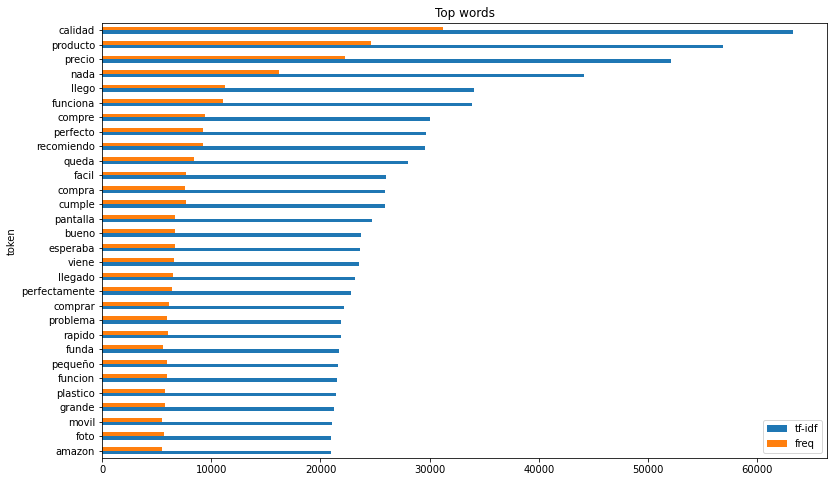

In [ ]:
new_df[['tf-idf','freq']][:30].sort_values(by='tf-idf',ascending=True).plot(kind='barh', figsize=(13,8), title='Top words')

**Analyzing N-Grams**

We've been working with unigrams (single words), so now, we're going to look for the frequency of bigrams (sequencesof token of length 2) in the documents.

Most of the bigrams contain stop words. Thus, it is advisable to build bigrams
without stop words.

In [ ]:
# We create the bigrams on all tokens but keep only those that do not contain any stop words
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
  return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)]) if len([t for t in ngram if t in stopwords])==0]

In [ ]:
bigrams = analysis_df.clean_body.apply(token_analysis).apply(ngrams, stopwords=stopwords)
trigrams = analysis_df.clean_body.apply(token_analysis).apply(ngrams, n=3, stopwords=stopwords)

In [ ]:
bigrams_tf_idf = compute_idf(bigrams).join(count_words(bigrams))
trigrams_tf_idf = compute_idf(trigrams).join(count_words(trigrams))

In [ ]:
bigrams_tf_idf['tf-idf'] = bigrams_tf_idf.idf * bigrams_tf_idf.freq
bigrams_tf_idf = bigrams_tf_idf.sort_values(by='tf-idf', ascending=False)

In [ ]:
bigrams_tf_idf.head(10)

,df,idf,freq,tf-idf
token,,,,
calidad precio,5594,3.676623,5606,20611.147259
relacion calidad,2954,4.315157,2957,12759.919788
mala calidad,2557,4.459483,2586,11532.222185
100 %,1504,4.990189,1532,7644.969764
unica pega,1361,5.090098,1363,6937.803087
funciona perfectamente,1090,5.312140,1098,5832.729358
ningun problema,988,5.410390,994,5377.927608
funciona correctamente,710,5.740808,716,4110.418296
baja calidad,690,5.769381,695,4009.719828


In [ ]:
trigrams_tf_idf['tf-idf'] = trigrams_tf_idf.idf * trigrams_tf_idf.freq
trigrams_tf_idf = trigrams_tf_idf.sort_values(by='tf-idf', ascending=False)

In [ ]:
trigrams_tf_idf.head(10)

,df,idf,freq,tf-idf
token,,,,
relacion calidad precio,2897,4.334642,2900,12570.460779
recomiendo 100 %,232,6.859335,232,1591.365784
barato sale caro,165,7.200127,166,1195.221110
100 % recomendable,156,7.256217,156,1131.969796
recomendable 100 %,155,7.262648,155,1125.710367
relacion precio calidad,123,7.493888,123,921.748260
excelente relacion calidad,99,7.710953,99,763.384327
calidad precio inmejorable,83,7.887232,83,654.640259
producto calidad precio,82,7.899353,82,647.746979


In [ ]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
  wc = WordCloud(width=800, height=400, background_color= "black", colormap="Paired", max_font_size=150, max_words=max_words)
  # convert DataFrame into dict
  if type(word_freq) == pd.Series:
    counter = Counter(word_freq.fillna(0).to_dict())
  else:
    counter = word_freq
  # filter stop words in frequency counter
  if stopwords is not None:
    counter = {token:freq for (token, freq) in counter.items() if token not in stopwords}
  wc.generate_from_frequencies(counter)
  plt.title(title, fontsize = 15)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")

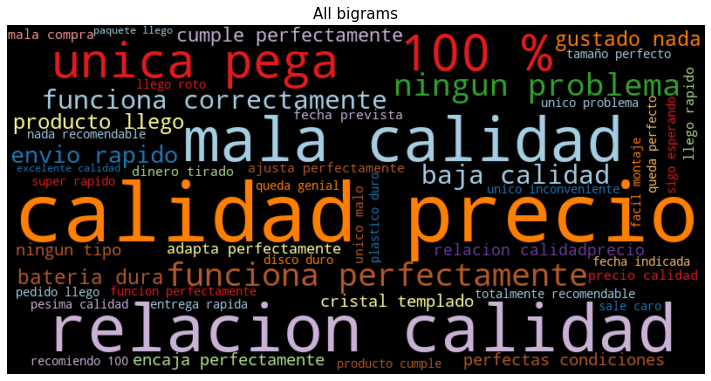

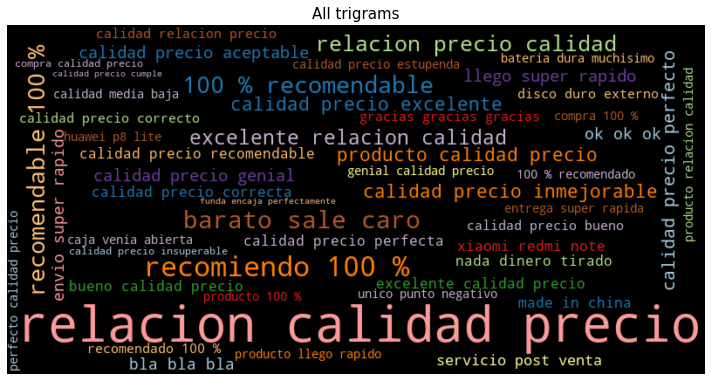

In [ ]:
n_grams = [bigrams_tf_idf, trigrams_tf_idf]
names = ['bigrams', 'trigrams']

for df, names in zip(n_grams, names):
    plt.figure(figsize=(12.5,10))
    wordcloud(df['tf-idf'], title=f'All {names}', max_words=50)
    plt.show()

### Train and evaluate ML models

**Text Representation (Vectorization)**

Bag of Words for classification create a bias toward the most frequent words as they have the highest numbers in the document matrix, so we'll use tf-idf.

In [ ]:
X = analysis_df.preprocessed
y = analysis_df.stars

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=94)

We will use f1 as an evaluation measure as classes are not perfectly balanced.

**Naive Bayes Classifier** (Benchmark model)

In [ ]:
%%time

pipe_nv = make_pipeline(TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3), min_df=5, max_df=0.7, max_features=5000, use_idf=False), MultinomialNB())
scores_nv_acc = cross_val_score(pipe_nv, X_train, y_train, scoring='accuracy', n_jobs=-1)
scores_nv_f1 = cross_val_score(pipe_nv, X_train, y_train, scoring='f1_macro', n_jobs=-1)

CPU times: user 1.39 s, sys: 159 ms, total: 1.55 s
Wall time: 1min 53s


In [ ]:
print(f'Accuracy score: {scores_nv_acc.mean():.4f} ({scores_nv_acc.std():.4f})')
print(f'F1 score: {scores_nv_f1.mean():.4f} ({scores_nv_f1.std():.4f})')

Accuracy score: 0.4542 (0.0024)
F1 score: 0.4495 (0.0028)


As the metrics obtained from the multiclass classification problem are too low, we are going to convert it to a binary problem deciding if it is a negative or positive review. 

We are going to assume that stars=3 is a positive review.

In [ ]:
scores_pd = pd.DataFrame(columns=['Model','Hyperparameters','Scores'])

In [ ]:
# Converting from multiclass to binary class
analysis_df_2 = analysis_df.copy()
analysis_df_2['stars'] = analysis_df_2.stars.map({1:0, 2:0, 3:1, 4:1, 5:1})

In [ ]:
# Train test split

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(analysis_df_2.preprocessed, analysis_df_2.stars, test_size=0.2, stratify=analysis_df_2.stars, random_state=94)

In [ ]:
scores_nb_bin_acc = cross_val_score(pipe_nv, X_train_bin, y_train_bin, scoring='accuracy', n_jobs=-1)
scores_nb_bin_f1 = cross_val_score(pipe_nv, X_train_bin, y_train_bin, scoring='f1', n_jobs=-1)
print(f'Accuracy score: {scores_nb_bin_acc.mean():.4f} ({scores_nb_bin_acc.std():.4f})')
print(f'F1 score: {scores_nb_bin_f1.mean():.4f} ({scores_nb_bin_f1.std():.4f})')

Accuracy score: 0.7794 (0.0012)
F1 score: 0.8265 (0.0010)


Naive Bayes hyperparameters optimization

In [ ]:
# Define model
model_nb = MultinomialNB()

# Repeated stratified K-fold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=94)

# Pipeline
pipe_nv = Pipeline(steps=[('tfidf',TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3), min_df=5, max_df=0.7, max_features=5000, use_idf=False)),
                          ('model_nb',model_nb)])

# Parameter grid
grid_param_nv = {'model_nb__alpha': np.linspace(0, 2, 10, endpoint=True)}

# Grid Search
gridsearchcv_nb = GridSearchCV(pipe_nv, grid_param_nv, scoring='f1', cv=cv)
gridsearchcv_nb.fit(X_train_bin, y_train_bin)

In [ ]:
print('Best parameters: {}'.format(gridsearchcv_nb.best_params_))
print('Best cross validation score: {:.4f}'.format(gridsearchcv_nb.best_score_))

Best parameters: {'model_nb__alpha': 2.0}
Best cross validation score: 0.8263


In [ ]:
scores_pd.loc[0] = ['Naive Bayes', 'Default hyperparameters', 0.8265]

In [ ]:
y_preds_nb = gridsearchcv_nb.predict(X_test_bin)

In [ ]:
scores_nb = f1_score(y_test_bin, y_preds_nb)
print(f'F1 score: {scores_nb:.4f}')

F1 score: 0.8260


**Suppor Vector Machine**


In [ ]:
%%time

pipe_svm = make_pipeline(TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3), min_df=5, max_features=5000), LinearSVC(random_state=94))
scores_svm = cross_val_score(pipe_svm, X_train_bin, y_train_bin, scoring='f1', n_jobs=-1)

CPU times: user 684 ms, sys: 119 ms, total: 803 ms
Wall time: 1min 6s


In [ ]:
print(f'F1 score: {scores_svm.mean():.4f} ({scores_svm.std():.4f})')

F1 score: 0.8264 (0.0012)


SVC hyperparameters optimization

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=94)
model = LinearSVC(random_state=42)
grid_param = {'tfidf__min_df': [5, 10],
              'tfidf__ngram_range': [(1, 3), (1, 5)],
              'tfidf__max_features':[3000, 5000],
              'model__tol': [1e-5, 1e-4],
              'model__C': [0.1, 1, 10],
              'model__loss': ['hinge']}
training_pipeline_svm = Pipeline(steps=[('tfidf',TfidfVectorizer(stop_words=stopwords, lowercase=False)), ('model',model)])
gridsearch_svc = RandomizedSearchCV(training_pipeline_svm, grid_param, scoring='f1', cv=cv, n_jobs=-1)
gridsearch_svc.fit(X_train_bin, y_train_bin)
best_params_svm_lin = gridsearch_svc.best_params_
best_result_svm_lin = gridsearch_svc.best_score_

In [ ]:
print('Best Linear_SVC parameters: {}'.format(best_params_svm_lin))
print('Best Linear_SVC cross validation score: {:.4f}'.format(best_result_svm_lin))

Best SVC parameters: {'tfidf__ngram_range': (1, 5), 'tfidf__min_df': 10, 'tfidf__max_features': 3000, 'model__tol': 0.0001, 'model__loss': 'hinge', 'model__C': 0.1}
Best SVC cross validation score: 0.8287


In [ ]:
scores_pd.loc[1] = ['SVM', "{'tfidf__ngram_range': (1, 5), 'tfidf__min_df': 10, 'tfidf__max_features': 3000, 'model__tol': 0.0001, 'model__loss': 'hinge', 'model__C': 0.1}", 0.8287]

**Logistic Regression**

In [ ]:
%%time

pipe_lr = make_pipeline(TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3), min_df=5, max_features=5000), LogisticRegression(random_state=94))
scores_lr = cross_val_score(pipe_lr, X_train_bin, y_train_bin, scoring='f1', n_jobs=-1)

CPU times: user 610 ms, sys: 127 ms, total: 737 ms
Wall time: 1min 12s


In [ ]:
print(f'F1 score: {scores_lr.mean():.4f} ({scores_lr.std():.4f})')

F1 score: 0.8287 (0.0018)


Logistic Regression hyperparameters optimization

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, random_state=94)
lr_model = LogisticRegression(random_state=94)
lr_grid_params = {'tfidf__min_df': [5, 10],
                  'tfidf__ngram_range': [(1, 3), (1, 5)],
                  'tfidf__max_features':[3000, 5000],
                  'lr_model__penalty':['l1','l2'],
                  'lr_model__C': np.logspace(1,10,10)}

training_pipeline_lr = Pipeline(steps=[('tfidf',TfidfVectorizer(stop_words=stopwords, lowercase=False)), ('lr_model',lr_model)])

gridsearch_lr = RandomizedSearchCV(training_pipeline_lr, lr_grid_params, scoring='f1', cv=cv, n_jobs=-1)
gridsearch_lr.fit(X_train_bin, y_train_bin)

In [ ]:
print('Best Logistic Regression parameters: {}'.format(gridsearch_lr.best_params_))
print('Best cross validation score: {:.4f}'.format(gridsearch_lr.best_score_))

Best Logistic Regression parameters: {'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 5, 'tfidf__max_features': 5000, 'lr_model__penalty': 'l2', 'lr_model__C': 10.0}
Best cross validation score: 0.8254


In [ ]:
scores_pd.loc[2] = ['Logistic Regression', 'Default hyperparameters', 0.8287]

***Best ML model***

In [ ]:
scores_pd.sort_values(['Scores','Model'],ascending=False).iloc[1]

Model                  Logistic Regression
Hyperparameters    Default hyperparameters
Scores                              0.8287
Name: 2, dtype: object

In [ ]:
pipe_lr.fit(X_train_bin, y_train_bin)
y_preds = pipe_lr.predict(X_test_bin)
print(classification_report(y_test_bin, y_preds))

              precision    recall  f1-score   support

           0       0.76      0.69      0.72     16000
           1       0.81      0.85      0.83     24000

    accuracy                           0.79     40000
   macro avg       0.78      0.77      0.78     40000
weighted avg       0.79      0.79      0.79     40000



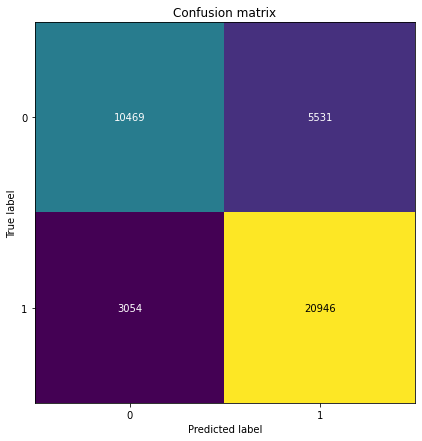

In [ ]:
plt.figure(figsize=(14,7))
scores_image = mglearn.tools.heatmap(confusion_matrix(y_test_bin, y_preds), xlabel='Predicted label', 
                                     ylabel='True label', xticklabels=list(np.unique(y_test_bin)), yticklabels=list(np.unique(y_test_bin)), fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

**Optimal Threshold Tuning**

As the default threshold for predicted probabilities is 0.5, we are going to define differents thresholds in order to find the optimal one that return the best f1 score (harmonic mean between precision and recall).

In [ ]:
# Apply differents thresholds
def threshold_tuning(pos_probs, threshold):
  return (pos_probs >= threshold).astype(int)

In [ ]:
# Predict probabilities
y_probs = pipe_lr.predict_proba(X_test_bin)

# Keep probabilities for the positive outcome only
probs = y_probs[:, 1]

# Define thresholds
thresholds = np.arange(0, 1, 0.05)

# Store f1 score for each threshold
scores = [f1_score(y_test_bin, threshold_tuning(probs, t)) for t in thresholds]

# Get best threshold
index = np.argmax(scores)

print('F1 score: {:.4f}\nThreshold: {}'.format(scores[index], thresholds[index]))

F1 score: 0.8314
Threshold: 0.4


In [ ]:
print(f'F1 score with probabiity threshold 0.5: {round(f1_score(y_test_bin, y_preds),4)}')

F1 score with probabiity threshold 0.5: 0.8289


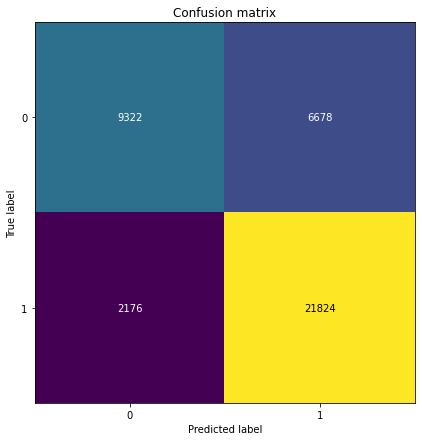

In [ ]:
plt.figure(figsize=(14,7))
scores_image = mglearn.tools.heatmap(confusion_matrix(y_test_bin, probs >= 0.4), xlabel='Predicted label', 
                                     ylabel='True label', xticklabels=list(np.unique(y_test_bin)), yticklabels=list(np.unique(y_test_bin)), fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

Comparing the two previous confusion matrices, it is seen that the increase of F1 score increase recall but decrease precision. This trade-off between precision and recall will depend on the bussiness goals.

**Model Interpretation**

In [ ]:
tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3), min_df=5, max_features=5000)
lr_model = LogisticRegression(random_state=94)

In [ ]:
mi_X_train = tf_idf.fit_transform(X_train_bin)
lr_model.fit(mi_X_train, y_train_bin)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=94, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
eli5.show_weights(lr_model, top=30, vec=tf_idf, target_names=['negative', 'positive'])

Weight?,Feature
+8.875,perfect
+6.625,encant
+5.369,unic peg
+5.331,genial
+4.783,excelent
+4.547,content
+4.354,ideal
+4.307,estupend
+3.965,perfeccion
+3.882,fenomenal


In [ ]:
# Performing Eli5 manually
pd_coeff = pd.DataFrame(lr_model.coef_[0], index=tf_idf.get_feature_names(), columns=['Coefficients'])

In [ ]:
pd_coeff_1 = pd_coeff.sort_values('Coefficients')[:10]
pd_coeff_1 = pd_coeff_1.append(pd_coeff.sort_values('Coefficients')[::-1][:10])

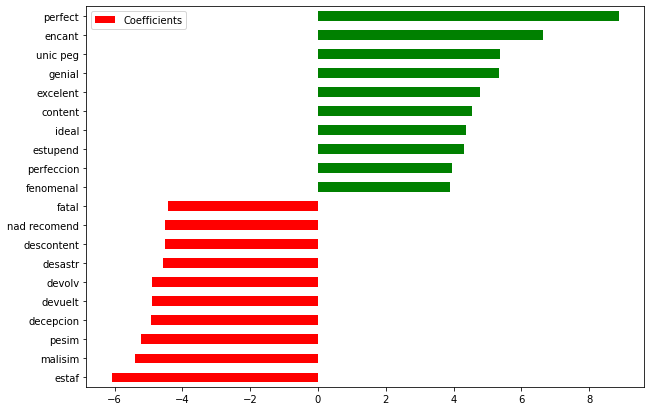

In [ ]:
pd_coeff_1.sort_values('Coefficients').plot(kind='barh',color=[['red']*10 + ['green']*10], figsize=(10,7))

**Next Steps**

Tf-idf vetorization has some drawbacks: they have sparse and high dimensional matrix, they are not able to capture the relationship between words and cannot deal correctly with out-of-vocabulary words.

For these reasons we will try with other type of feature engineering called *Word Embeddings* (a technique that uses neural networks to create dense and low dimensional vectors). Moreover, we will also use deep learning to predict classes and see if the results improves from the previously obtained. This said, the next steps in this projects are:

* Apply Word2vec for texts representations.
* Train and evaluate a Logistic Regression model to compare how much F1 changes with the new features.
* Train and evaluate a neural network wit the new feature vectors and compare it with the results of the trained Logistic Regression from the previous step.

Once feature engineering is done, at least I expect to improve the Logistic Regression performance fed by the embedded vector.